# 1. Install and import libraries, import data

In [ ]:
#! pip install --quiet lightning && pip install --quiet transformers && pip install --quiet emoji && pip install --quiet demoji && pip install --quiet googletrans > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.9 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
!pip install transformers torch accelerate torchmetrics pytorch_lightning > /dev/null 2>&1

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import string
import torch
import torchmetrics
import torch.utils.data
#import nltk
from os import listdir
from os.path import join
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from torchmetrics.functional import accuracy

In [ ]:
# import sys, os
# if 'google.colab' in sys.modules:
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     path_to_file = '/content/gdrive/My Drive/BT5153 Group Project/Code'
#     print(path_to_file)
#     os.chdir(path_to_file)
#     !pwd


import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/Colab/BT5153/Group Project/BT5153 Group Project/Code' # Replace with personal drive link
    print(path_to_file)
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab/BT5153/Group Project/BT5153 Group Project/Code
/content/gdrive/.shortcut-targets-by-id/161MtoW1UEaHJpWRm6XEiXUCod9ZTjhqM/BT5153 Group Project/Code


In [ ]:
# Set path to train data
path_train = os.path.join(path_to_file, 'tweet_emotions.csv')
print(path_train)

# # Set path to output data
path_lyrics = os.path.join(path_to_file, 'predict_example_lyrics_T5.csv')
print(path_lyrics)

#path_contractions = os.path.join(path_to_file, 'contractions.csv')
# print(path_contractions)

path_lyrics_lawunn = os.path.join(path_to_file, 'lyrics_lawunn.csv')
print(path_lyrics_lawunn)

path_lyrics_matt = os.path.join(path_to_file, 'lyrics_matt.csv')
print(path_lyrics_matt)

path_lyrics_testing = os.path.join(path_to_file, 'lyrics_testing.csv')
print(path_lyrics_testing)

/content/gdrive/My Drive/Colab/BT5153/Group Project/BT5153 Group Project/Code/tweet_emotions.csv
/content/gdrive/My Drive/Colab/BT5153/Group Project/BT5153 Group Project/Code/lyrics_testing.csv


In [ ]:
train_df = pd.read_csv(path_train)
lyrics_df = pd.read_csv(path_lyrics)
lyrics_lw = pd.read_csv('lyrics_lawunn.csv')
lyrics_matt = pd.read_csv('lyrics_matt.csv')
#lyrics_test = pd.read_csv('raw in progress/lyrics_testing.csv', sep = ';')
lyrics_test = pd.read_csv('raw in progress/lyrics_testing.csv', sep=';', encoding='ISO-8859-1')


In [ ]:
display(train_df.head(10))
display(lyrics_df.head(10))
display(lyrics_lw.head(10))
display(lyrics_matt.head(10))
display(lyrics_test.head(10))

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?


In [ ]:
# Set the seed
seed = 42
seed_everything(seed, workers=True)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

# 2. Emotion Detection with T5-small (all emotions)

https://huggingface.co/docs/transformers/model_doc/t5

## 2.1 Training and testing process

### 2.1.1 Label exploration and model initialisation

In [ ]:
train_df['sentiment'].value_counts()

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

**Sentiment labels in the train dataset**

| Labels     | Count |
|------------|-------|
| neutral    | 8638  |
| worry      | 8459  |
| happiness  | 5209  |
| sadness    | 5165  |
| love       | 3842  |
| surprise   | 2187  |
| fun        | 1776  |
| relief     | 1526  |
| hate       | 1323  |
| empty      | 827   |
| enthusiasm | 759   |
| boredom    | 179   |
| anger      | 110   |


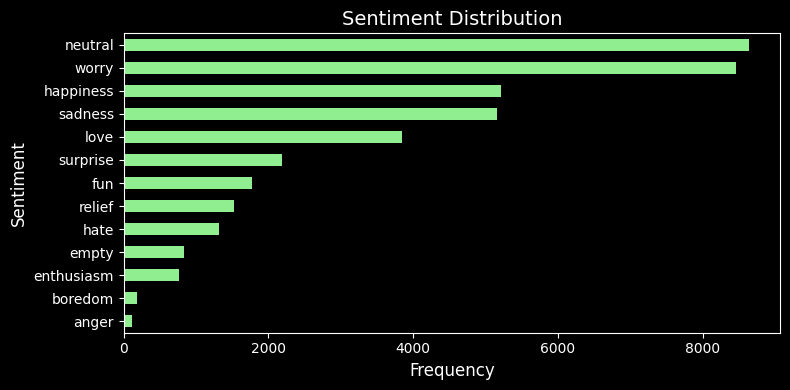

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'sentiment_counts' is your series with sentiment counts
sentiment_counts = train_df['sentiment'].value_counts()

# Set the style of the plot to use a dark background
plt.style.use('dark_background')

# Creating a horizontal bar chart with adjusted features
plt.figure(figsize=(8, 4))  # Adjust figure size
ax = sentiment_counts.sort_values().plot(kind='barh', color='lightgreen')
plt.title('Sentiment Distribution', fontsize=14, color='white')  # Adjust title font size
plt.xlabel('Frequency', fontsize=12, color='white')  # Adjust x-axis label font size
plt.ylabel('Sentiment', fontsize=12, color='white')  # Adjust y-axis label font size
plt.xticks(fontsize=10, color='white')  # Adjust x-axis tick font size
plt.yticks(fontsize=10, color='white')  # Adjust y-axis tick font size

# Reduce the space between bars
#ax.bar_label(ax.containers[0], label_type='center', fontsize=8)

plt.tight_layout()  # This will fit your plot within the figure area nicely
plt.show()

In [ ]:
# Initialize the model
model_name = 't5-small'
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Initialize the T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Get the number of expected labels
num_labels = model.config.num_labels
print("Number of Expected Labels:", num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Number of Expected Labels: 2


### 2.1.2. Split data for training and testing


In [ ]:
def prepare_data_splits(df, text_column, label_column, test_size=0.2, val_size=0.25):
    """
    Prepare train, validation, and test splits for given text and label columns.

    Args:
    df (DataFrame): The dataframe containing text and labels.
    text_column (str): Column name for text data.
    label_column (str): Column name for label data.
    test_size (float): Proportion of dataset to include in the test split.
    val_size (float): Proportion of train dataset to include in the validation split.

    Returns:
    dict: A dictionary containing train, validation, and test texts and labels.
    """
    texts = df[text_column].tolist()
    #labels = df[label_column].to_numpy()
    labels = df[label_column].tolist()

    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, test_size=test_size, stratify=labels)

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts, train_labels, test_size=val_size, stratify=train_labels)

    return {
        'train_texts': train_texts,
        'train_labels': train_labels,
        'val_texts': val_texts,
        'val_labels': val_labels,
        'test_texts': test_texts,
        'test_labels': test_labels
    }

In [ ]:
preprocessing_variants = {
    'sentiment':'sentiment'
}

data_splits = {}

for column, abbreviation in preprocessing_variants.items():
    data_splits[abbreviation] = prepare_data_splits(
        df=train_df,
        text_column=column,
        label_column='sentiment'
    )

### 2.1.3. Prepare Dataloader

In [ ]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, prefix="classify emotion: ", max_length=512, device='cpu'):
        formatted_texts = [prefix + text for text in texts]
        self.encodings = tokenizer(formatted_texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        self.encodings = {key: val.to(device) for key, val in self.encodings.items()}

        label_encodings = tokenizer(labels, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        self.labels = label_encodings['input_ids'].to(device)

        self.device = device

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx] for key in self.encodings}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

def prepare_data_for_model(train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, tokenizer, prefix, device):
    train_dataset = ReviewsDataset(train_texts, train_labels, tokenizer, prefix=prefix, device=device)
    val_dataset = ReviewsDataset(val_texts, val_labels, tokenizer, prefix=prefix, device=device)
    test_dataset = ReviewsDataset(test_texts, test_labels, tokenizer, prefix=prefix, device=device)
    return train_dataset, val_dataset, test_dataset

### 2.1.4. Lightning model definition

In [ ]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, learning_rate=5e-5, tokenizer=None, model = None):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.tokenizer = tokenizer

    def forward(self, input_ids, attention_mask=None, labels=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return output

    def training_step(self, batch, batch_idx):
        output = self.forward(**batch)
        loss = output.loss
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'preds': output.logits, 'labels': batch['labels']}

    def validation_step(self, batch, batch_idx):
        output = self.forward(**batch)
        loss = output.loss
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        decoded_preds = self.tokenizer.batch_decode(torch.argmax(output.logits, -1), skip_special_tokens=True)
        decoded_labels = [self.tokenizer.decode(label, skip_special_tokens=True) for label in batch['labels']]
        exact_match = torch.tensor([pred == label for pred, label in zip(decoded_preds, decoded_labels)]).float().mean()
        self.log('val_exact_match', exact_match, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {'val_loss': loss, 'val_exact_match': exact_match}

    def test_step(self, batch, batch_idx):
        output = self.forward(**batch)
        decoded_preds = self.tokenizer.batch_decode(torch.argmax(output.logits, -1), skip_special_tokens=True)
        decoded_labels = [self.tokenizer.decode(label, skip_special_tokens=True) for label in batch['labels']]
        exact_matches = [pred == label for pred, label in zip(decoded_preds, decoded_labels)]
        self.log("test_loss", output.loss, prog_bar=True)
        return {'test_loss': output.loss, 'exact_matches': exact_matches}




    def predict(self, batch):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask'] if 'attention_mask' in batch else None
        generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask)

        predictions = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        return predictions

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [ ]:
def prepare_model(model_name):
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    return model

def train_model_for_preprocessing_variant(df, preprocessing_variant, label_column, model_name="t5-small", prefix='classify emotion: ', max_epochs=1, device='cpu'):
    tokenizer = T5Tokenizer.from_pretrained(model_name)

    print("Using column for training:", preprocessing_variant)
    train_texts = df[preprocessing_variant].tolist()

    model_dir = f"models/t5/{preprocessing_variant}"
    os.makedirs(model_dir, exist_ok=True)

    logger = TensorBoardLogger(save_dir=model_dir, name="training_logs")

    data_splits = prepare_data_splits(df, preprocessing_variant, label_column)
    train_texts, val_texts, test_texts = data_splits['train_texts'], data_splits['val_texts'], data_splits['test_texts']
    train_labels, val_labels, test_labels = data_splits['train_labels'], data_splits['val_labels'], data_splits['test_labels']

    train_dataset, val_dataset, test_dataset = prepare_data_for_model(
        train_texts=train_texts,
        val_texts=val_texts,
        test_texts=test_texts,
        train_labels=train_labels,
        val_labels=val_labels,
        test_labels=test_labels,
        tokenizer=tokenizer,
        prefix=prefix,
        device=device
    )

    train_loader = DataLoader(dataset=train_dataset, batch_size=5, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=5, shuffle=False, num_workers=2)
    test_loader = DataLoader(dataset=test_dataset, batch_size=5, shuffle=False, num_workers=2)

    model = prepare_model(model_name)

    lightning_model = T5FineTuner(model=model, tokenizer = tokenizer)

    checkpoint_callback = ModelCheckpoint(
        dirpath=f"models/t5/{preprocessing_variant}",
        filename='best_checkpoint',
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='max',
        save_last=False
    )

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=checkpoint_callback,
        accelerator='gpu',
        #accelerator='cpu',
        #accelerator="auto"
        logger=logger,
        log_every_n_steps=1,
    )

    trainer.fit(model=lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(model=lightning_model, dataloaders=test_loader, ckpt_path="best")

    return trainer, lightning_model

### 2.1.5. Model training with labeled data

In [ ]:
def train_and_save_models(df, preprocessing_variants, label_column, model_name="t5-small", base_path= path_to_file, prefix='classify emotion: ', device = 'cpu', max_epochs=1):
    t5_trained_models = {}
    for description, column_name in preprocessing_variants.items():
        print(f"Training model for preprocessing variant: {description}")
        trainer, trained_model = train_model_for_preprocessing_variant(
            df=df,
            preprocessing_variant=column_name,
            label_column=label_column,
            model_name=model_name,
            prefix = prefix,
            device = device,
            max_epochs = max_epochs
        )

        t5_trained_models[description] = (trainer, trained_model)

    return t5_trained_models

t5_trained_models = train_and_save_models(df = train_df, preprocessing_variants = preprocessing_variants, label_column = 'sentiment', prefix = 'classify emotion: ', device='cpu', max_epochs = 10)

Training model for preprocessing variant: sentiment


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Using column for training: sentiment


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/gdrive/.shortcut-targets-by-id/161MtoW1UEaHJpWRm6XEiXUCod9ZTjhqM/BT5153 Group Project/Code/models/t5/sentiment exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 4800: 'val_loss' reached 0.00000 (best 0.00000), saving model to '/content/gdrive/.shortcut-targets-by-id/161MtoW1UEaHJpWRm6XEiXUCod9ZTjhqM/BT5153 Group Project/Code/models/t5/sentiment/best_checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 9600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 14400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 19200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 24000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 28800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 33600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 38400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 43200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 48000: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/gdrive/.shortcut-targets-by-id/161MtoW1UEaHJpWRm6XEiXUCod9ZTjhqM/BT5153 Group Project/Code/models/t5/sentiment/best_checkpoint-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/gdrive/.shortcut-targets-by-id/161MtoW1UEaHJpWRm6XEiXUCod9ZTjhqM/BT5153 Group Project/Code/models/t5/sentiment/best_checkpoint-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    7.6769742918259e-07    │
└───────────────────────────┴───────────────────────────┘

## 2.2. Inference on unlabelled data

### 2.2.1. Data split & preperation of Dataloader

In [ ]:
def prepare_data_prediction(df, text_column):
    """
    Prepare train, validation, and test splits for given text and label columns.

    Args:
    df (DataFrame): The dataframe containing text and labels.
    text_column (str): Column name for text data.
    Returns:
    dict: A dictionary containing train, validation, and test texts and labels.
    """
    texts = df[text_column].tolist()
    predict_texts = texts

    return {
        'predict_texts': predict_texts
    }

preprocessing_variants = {
    'sentiment':'sentiment'
}

In [ ]:
class ReviewsDataset_predict(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, prefix="Sentiment: ", max_length=512, device='cpu'):
        print(f"Type of tokenizer inside ReviewsDataset_predict: {type(tokenizer)}")
        formatted_texts = [prefix + text for text in texts]
        self.encodings = tokenizer(formatted_texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        self.encodings = {key: val.to(device) for key, val in self.encodings.items()}

        self.device = device

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx] for key in self.encodings}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

def prepare_texts_for_prediction(df, text_column, tokenizer, prefix, max_length=512, device='cpu'):
    print(f"Type of text_column: {type(text_column)}")
    texts = df[text_column].fillna('').astype(str).tolist()

    print(f"Type of texts (should be list of str): {type(texts)}")
    if texts:
        print(f"Type of the first item in texts: {type(texts[0])}")
    print(f"Type of tokenizer: {type(tokenizer)}")

    dataset = ReviewsDataset_predict(texts, tokenizer, prefix, max_length=max_length, device=device)
    return DataLoader(dataset=dataset, batch_size=16, shuffle=False)


def predict_and_update_all_rows(df, text_column, trained_model, tokenizer, prefix, device='cpu'):
    trained_model.to(device)
    trained_model.eval()
    predictions = []

    data_loader = prepare_texts_for_prediction(df, text_column, tokenizer, prefix, device=device)

    with torch.no_grad():
        for batch in data_loader:
            preds = trained_model.predict(batch)
            predictions.extend(preds)

    df[f'{text_column}_pred'] = predictions
    return df

def initialize_all_prediction_columns(df, preprocessing_variants):
    for variant in preprocessing_variants:
        df[f'{variant}_pred'] = None
    return df

def predict_and_append_all_columns(df, trained_models, tokenizer, prefix, device = 'cpu'):
    device = device
    for description, (trainer, model) in trained_models.items():
        if description in df.columns:
            print(f"Processing predictions for column: {description}")
            if hasattr(model, 'eval'):
                df = predict_and_update_all_rows(df, description, model, tokenizer, prefix, device)
            else:
                raise AttributeError("Model object does not have 'eval' method, check model extraction.")
        else:
            print(f"Column {description} does not exist in DataFrame.")
    return df

### 2.2.2. Inference

In [ ]:
lyrics_df.rename(columns={'processed_lyrics': 'sentiment'}, inplace=True)
display(lyrics_df.head())

,Participant_ID,Song_name,Artist,Spotify_ID,Genre,Audio_class,Lyrics,Sentiment_class,Audio + Lyrics analysis,Total_mental_health,...,Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions,sentiment
0,3,Bad guy,Billie Eilish,2Fxmhks0bxGSBdJ92vM42m,Pop,Relax,"White shirt now red, my bloody nose\n Sleepin'...",Positive,Relax,15,...,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,white shirt red bloody nose sleepin ' tippy to...
1,62,Bad Guy,Billie Eilish,2Fxmhks0bxGSBdJ92vM42m,Pop,Relax,"White shirt now red, my bloody nose\n Sleepin'...",Positive,Relax,15,...,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,white shirt red bloody nose sleepin ' tippy to...
2,3,Down,Jay Sean,7LP4Es66zdY7CyjepqmvAg,Pop,Happy,"What you really expect when I strut thru town,...",Positive,Happy,15,...,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,really expect strut thru town 2 3 day shut chi...
3,4,Something just like this,The Chainsmokers,6RUKPb4LETWmmr3iAEQktW,Pop,Relax,I've been reading books of old\n The legends a...,Positive,Relax,14,...,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,reading book old legend myth achilles gold her...
4,4,Complicated,Avril Lavigne,5xEM5hIgJ1jjgcEBfpkt2F,Pop,Happy,La la\n La la la la\n La la\n La la la\n I lik...,Positive,Happy,14,...,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,la la la la la la la la la la la like smile li...


In [ ]:
model_name = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(model_name)
prefix = 'classify emotion: '

try:
    lyrics_df = lyrics_df.copy()
    lyrics_predicted = predict_and_append_all_columns(df = lyrics_df, trained_models = t5_trained_models, tokenizer = tokenizer, prefix = prefix, device = 'cuda')
    print(lyrics_predicted[[col for col in lyrics_predicted.columns if 'pred' in col]].head())
except Exception as e:
    print(f"An error occurred: {e}")

# save to CSV
lyrics_predicted.to_csv('lyrics_pred.csv', index=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Processing predictions for column: sentiment
Type of text_column: <class 'str'>
Type of texts (should be list of str): <class 'list'>
Type of the first item in texts: <class 'str'>
Type of tokenizer: <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>
Type of tokenizer inside ReviewsDataset_predict: <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


                                      sentiment_pred
0  white shirt red bloody nose sleepin'tippy toe ...
1  white shirt red bloody nose sleepin'tippy toe ...
2  uh huh cause superstar know exactly must make ...
3               something like doodoodoo mmhmm doodo
4  la la la la la la la la la la la la la la la l...


In [ ]:
lyrics_predicted.head(15)

,Participant_ID,Song_name,Artist,Spotify_ID,Genre,Audio_class,Lyrics,Sentiment_class,Audio + Lyrics analysis,Total_mental_health,...,Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions,sentiment,sentiment_pred
0,3,Bad guy,Billie Eilish,2Fxmhks0bxGSBdJ92vM42m,Pop,Relax,"White shirt now red, my bloody nose\n Sleepin'...",Positive,Relax,15,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,white shirt red bloody nose sleepin ' tippy to...,white shirt red bloody nose sleepin'tippy toe ...
1,62,Bad Guy,Billie Eilish,2Fxmhks0bxGSBdJ92vM42m,Pop,Relax,"White shirt now red, my bloody nose\n Sleepin'...",Positive,Relax,15,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,white shirt red bloody nose sleepin ' tippy to...,white shirt red bloody nose sleepin'tippy toe ...
2,3,Down,Jay Sean,7LP4Es66zdY7CyjepqmvAg,Pop,Happy,"What you really expect when I strut thru town,...",Positive,Happy,15,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,really expect strut thru town 2 3 day shut chi...,uh huh cause superstar know exactly must make ...
3,4,Something just like this,The Chainsmokers,6RUKPb4LETWmmr3iAEQktW,Pop,Relax,I've been reading books of old\n The legends a...,Positive,Relax,14,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,reading book old legend myth achilles gold her...,something like doodoodoo mmhmm doodo
4,4,Complicated,Avril Lavigne,5xEM5hIgJ1jjgcEBfpkt2F,Pop,Happy,La la\n La la la la\n La la\n La la la\n I lik...,Positive,Happy,14,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,la la la la la la la la la la la like smile li...,la la la la la la la la la la la la la la la l...
5,4,This feeling,The Chainsmokers,4NBTZtAt1F13VvlSKe6KTl,Pop,Relax,I'll tell you a story before it tells itself\n...,Positive,Relax,14,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,tell story tell lay reason say need help got e...,aheah yeaheah yeaheaheaheah yeahe
6,5,Lose You To Love Me,Selena Gomez,4l0Mvzj72xxOpRrp6h8nHi,Pop,Sad,You promised the world and I fell for it\n I p...,Positive,Sad,11,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,promised world fell put first adored set fire ...,love yeah love love yeah love yeah love yeah n...
7,6,Sit Still Look Pretty,Daya,0Mlm5SrNK34Jqn8Rk1Gs3g,Pop,Happy,Could dress up\nTo get love\nBut guess what?\n...,Positive,Happy,9,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,could dress get love guess ? never going girl ...,? never going girl whois living barbie world c...
8,6,Sorry Not Sorry,Demi Lovato,7gvd8xj4QgPqbQSsn5pV7d,Pop,Relax,"Payback is a bad bitch\n And baby, I'm the bad...",Positive,Relax,9,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,payback bad bitch baby baddest looking like re...,'re fuckin'like 10 best ever yeah know bad mus...
9,6,Teeth,5 Seconds Of Summer,1JRK7srBWUtAW7dPabKBwJ,Pop,Happy,"Some days, you're the only thing I know\nOnly ...",Positive,Happy,9,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,day thing know thing thatis burning night grow...,never never let go devil put hand never never ...


# 3. Sentiment analysis with T5-base (3 classes)

**Sentiment labels in the train dataset**

| Labels     | Count |
|------------|-------|
| neutral    | 8638  |
| worry      | 8459  |
| happiness  | 5209  |
| sadness    | 5165  |
| love       | 3842  |
| surprise   | 2187  |
| fun        | 1776  |
| relief     | 1526  |
| hate       | 1323  |
| empty      | 827   |
| enthusiasm | 759   |
| boredom    | 179   |
| anger      | 110   |


In [ ]:
model_name = 't5-base'
model = T5ForConditionalGeneration.from_pretrained(model_name)

tokenizer = T5Tokenizer.from_pretrained('t5-base')

num_labels = model.config.num_labels
print("Number of Expected Labels:", num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have

Number of Expected Labels: 2


## 3.1. Label preprocessing



In [ ]:
import pandas as pd

# Step 1: Rename the current 'sentiment' column
train_df.rename(columns={'sentiment': 'sentiment_full'}, inplace=True)

In [ ]:
# Step 2: Create a mapping dictionary for sentiment grouping
sentiment_map = {
    'happiness': 'positive',
    'love': 'positive',
    'fun': 'positive',
    'enthusiasm': 'positive',
    'neutral': 'neutral',
    'relief': 'neutral',
    'boredom': 'neutral',
    'surprise': 'neutral',
    'worry': 'negative',
    'sadness': 'negative',
    'hate': 'negative',
    'empty': 'negative',
    'anger': 'negative'
}

# Step 3: Apply the mapping to create a new 'sentiment' column
train_df['sentiment'] = train_df['sentiment_full'].map(sentiment_map)

In [ ]:
# Now 'train_df' has the new 'sentiment' column with grouped sentiment labels
display(train_df[['sentiment_full', 'sentiment']])

,sentiment_full,sentiment
0,empty,negative
1,sadness,negative
2,sadness,negative
3,enthusiasm,positive
4,neutral,neutral
...,...,...
39995,neutral,neutral
39996,love,positive
39997,love,positive
39998,happiness,positive


## 3.2 Train and testing process

### 3.2.1 Data split


In [3]:
def prepare_data_splits(df, text_column, label_column, test_size=0.2, val_size=0.25):
    """
    Prepare train, validation, and test splits for given text and label columns.

    Args:
    df (DataFrame): The dataframe containing text and labels.
    text_column (str): Column name for text data.
    label_column (str): Column name for label data.
    test_size (float): Proportion of dataset to include in the test split.
    val_size (float): Proportion of train dataset to include in the validation split.

    Returns:
    dict: A dictionary containing train, validation, and test texts and labels.
    """
    texts = df[text_column].tolist()
    labels = df[label_column].tolist()

    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, test_size=test_size, stratify=labels)

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts, train_labels, test_size=val_size, stratify=train_labels)

    return {
        'train_texts': train_texts,
        'train_labels': train_labels,
        'val_texts': val_texts,
        'val_labels': val_labels,
        'test_texts': test_texts,
        'test_labels': test_labels
    }

In [ ]:
preprocessing_variants = {
    'sentiment':'sentiment'
}

data_splits = {}

for column, abbreviation in preprocessing_variants.items():
    data_splits[abbreviation] = prepare_data_splits(
        df=train_df,
        text_column=column,
        label_column='sentiment'
    )

### 3.2.2 preparation of Dataloader

In [ ]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, prefix="classify emotion: ", max_length=512, device='cpu'):
        formatted_texts = [prefix + text for text in texts]
        self.encodings = tokenizer(formatted_texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        self.encodings = {key: val.to(device) for key, val in self.encodings.items()}

        label_encodings = tokenizer(labels, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        self.labels = label_encodings['input_ids'].to(device)

        self.device = device

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx] for key in self.encodings}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

def prepare_data_for_model(train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, tokenizer, prefix, device):
    train_dataset = ReviewsDataset(train_texts, train_labels, tokenizer, prefix=prefix, device=device)
    val_dataset = ReviewsDataset(val_texts, val_labels, tokenizer, prefix=prefix, device=device)
    test_dataset = ReviewsDataset(test_texts, test_labels, tokenizer, prefix=prefix, device=device)
    return train_dataset, val_dataset, test_dataset

### 3.2.3 Lightning model definition

In [ ]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, learning_rate=5e-5, tokenizer=None, model = None):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.tokenizer = tokenizer

    def forward(self, input_ids, attention_mask=None, labels=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return output

    def training_step(self, batch, batch_idx):
        output = self.forward(**batch)
        loss = output.loss
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'preds': output.logits, 'labels': batch['labels']}

    def validation_step(self, batch, batch_idx):
        output = self.forward(**batch)
        loss = output.loss
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        decoded_preds = self.tokenizer.batch_decode(torch.argmax(output.logits, -1), skip_special_tokens=True)
        decoded_labels = [self.tokenizer.decode(label, skip_special_tokens=True) for label in batch['labels']]
        exact_match = torch.tensor([pred == label for pred, label in zip(decoded_preds, decoded_labels)]).float().mean()
        self.log('val_exact_match', exact_match, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {'val_loss': loss, 'val_exact_match': exact_match}

    def test_step(self, batch, batch_idx):
        output = self.forward(**batch)
        decoded_preds = self.tokenizer.batch_decode(torch.argmax(output.logits, -1), skip_special_tokens=True)
        decoded_labels = [self.tokenizer.decode(label, skip_special_tokens=True) for label in batch['labels']]
        exact_matches = [pred == label for pred, label in zip(decoded_preds, decoded_labels)]
        self.log("test_loss", output.loss, prog_bar=True)
        return {'test_loss': output.loss, 'exact_matches': exact_matches}

    def predict(self, batch):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask'] if 'attention_mask' in batch else None

        generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask)

        predictions = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        return predictions

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [ ]:
def prepare_model(model_name):
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    return model

def train_model_for_preprocessing_variant(df, preprocessing_variant, label_column, model_name="t5-small", prefix='classify emotion: ', max_epochs=1, device='cpu'):
    tokenizer = T5Tokenizer.from_pretrained(model_name)

    print("Using column for training:", preprocessing_variant)
    train_texts = df[preprocessing_variant].tolist()

    model_dir = f"models/t5/{preprocessing_variant}"
    os.makedirs(model_dir, exist_ok=True)

    logger = TensorBoardLogger(save_dir=model_dir, name="training_logs")

    data_splits = prepare_data_splits(df, preprocessing_variant, label_column)
    train_texts, val_texts, test_texts = data_splits['train_texts'], data_splits['val_texts'], data_splits['test_texts']
    train_labels, val_labels, test_labels = data_splits['train_labels'], data_splits['val_labels'], data_splits['test_labels']

    train_dataset, val_dataset, test_dataset = prepare_data_for_model(
        train_texts=train_texts,
        val_texts=val_texts,
        test_texts=test_texts,
        train_labels=train_labels,
        val_labels=val_labels,
        test_labels=test_labels,
        tokenizer=tokenizer,
        prefix=prefix,
        device=device
    )

    train_loader = DataLoader(dataset=train_dataset, batch_size=5, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=5, shuffle=False, num_workers=2)
    test_loader = DataLoader(dataset=test_dataset, batch_size=5, shuffle=False, num_workers=2)

    model = prepare_model(model_name)

    lightning_model = T5FineTuner(model=model, tokenizer = tokenizer)

    checkpoint_callback = ModelCheckpoint(
        dirpath=f"models/t5/{preprocessing_variant}",
        filename='best_checkpoint',
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='max',
        save_last=False
    )

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=checkpoint_callback,
        accelerator='gpu',
        #accelerator='cpu',
        #accelerator="auto"
        logger=logger,
        log_every_n_steps=1,
    )

    trainer.fit(model=lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    result = trainer.test(model=lightning_model, dataloaders=test_loader, ckpt_path="best")
    return trainer, lightning_model, result



### 3.2.4 Model training with labeled data

In [ ]:
def train_and_save_models(df, preprocessing_variants, label_column, model_name="t5-base", base_path= path_to_file, prefix='classify emotion: ', device = 'cpu', max_epochs=1):
    t5_trained_models = {}
    for description, column_name in preprocessing_variants.items():
        print(f"Training model for preprocessing variant: {description}")
        trainer, trained_model, test_result = train_model_for_preprocessing_variant(
            df=df,
            preprocessing_variant=column_name,
            label_column=label_column,
            model_name=model_name,
            prefix = prefix,
            device = device,
            max_epochs = max_epochs
        )

        t5_trained_models[description] = (trainer, trained_model, test_result)

    return t5_trained_models

t5_trained_models = train_and_save_models(df = train_df.head(1000), preprocessing_variants = preprocessing_variants, label_column = 'sentiment', prefix = 'classify emotion: ', device='cpu', max_epochs = 3)

Training model for preprocessing variant: sentiment


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Using column for training: sentiment


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/gdrive/.shortcut-targets-by-id/161MtoW1UEaHJpWRm6XEiXUCod9ZTjhqM/BT5153 Group Project/Code/models/t5/sentiment exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
8

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 120: 'val_loss' reached 0.00008 (best 0.00008), saving model to '/content/gdrive/.shortcut-targets-by-id/161MtoW1UEaHJpWRm6XEiXUCod9ZTjhqM/BT5153 Group Project/Code/models/t5/sentiment/best_checkpoint-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 240: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 360: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/gdrive/.shortcut-targets-by-id/161MtoW1UEaHJpWRm6XEiXUCod9ZTjhqM/BT5153 Group Project/Code/models/t5/sentiment/best_checkpoint-v5.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/gdrive/.shortcut-targets-by-id/161MtoW1UEaHJpWRm6XEiXUCod9ZTjhqM/BT5153 Group Project/Code/models/t5/sentiment/best_checkpoint-v5.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   8.302395144710317e-05   │
└───────────────────────────┴───────────────────────────┘

## 3.3 Inference on unlabelled data

### 3.3.1 Data split and preparation of Dataloader

In [ ]:
def prepare_data_prediction(df, text_column):
    """
    Prepare train, validation, and test splits for given text and label columns.

    Args:
    df (DataFrame): The dataframe containing text and labels.
    text_column (str): Column name for text data.
    Returns:
    dict: A dictionary containing train, validation, and test texts and labels.
    """
    texts = df[text_column].tolist()
    predict_texts = texts

    return {
        'predict_texts': predict_texts
    }

preprocessing_variants = {
    'sentiment':'sentiment'
}

In [ ]:
class ReviewsDataset_predict(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, prefix="Sentiment: ", max_length=512, device='cpu'):
        print(f"Type of tokenizer inside ReviewsDataset_predict: {type(tokenizer)}")
        formatted_texts = [prefix + text for text in texts]
        self.encodings = tokenizer(formatted_texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        self.encodings = {key: val.to(device) for key, val in self.encodings.items()}

        self.device = device

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx] for key in self.encodings}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

def prepare_texts_for_prediction(df, text_column, tokenizer, prefix, max_length=512, device='cpu'):
    print(f"Type of text_column: {type(text_column)}")
    texts = df[text_column].fillna('').astype(str).tolist()

    print(f"Type of texts (should be list of str): {type(texts)}")
    if texts:
        print(f"Type of the first item in texts: {type(texts[0])}")
    print(f"Type of tokenizer: {type(tokenizer)}")

    dataset = ReviewsDataset_predict(texts, tokenizer, prefix, max_length=max_length, device=device)
    return DataLoader(dataset=dataset, batch_size=16, shuffle=False)


def predict_and_update_all_rows(df, text_column, trained_model, tokenizer, prefix, device='cpu'):
    trained_model.to(device)
    trained_model.eval()
    predictions = []

    data_loader = prepare_texts_for_prediction(df, text_column, tokenizer, prefix, device=device)

    with torch.no_grad():
        for batch in data_loader:
            preds = trained_model.predict(batch)
            predictions.extend(preds)

    df[f'{text_column}_pred'] = predictions
    return df

def initialize_all_prediction_columns(df, preprocessing_variants):
    for variant in preprocessing_variants:
        df[f'{variant}_pred'] = None
    return df

def predict_and_append_all_columns(df, trained_models, tokenizer, prefix, device='cpu'):
    for description, (trainer, model, test_result) in trained_models.items():
        if description in df.columns:
            print(f"Processing predictions for column: {description}")
            if hasattr(model, 'eval'):
                df = predict_and_update_all_rows(df, description, model, tokenizer, prefix, device)
            else:
                raise AttributeError("Model object does not have 'eval' method, check model extraction.")
        else:
            print(f"Column {description} does not exist in DataFrame.")
    return df

### 3.3.2 Inference on example lyrics

In [ ]:
lyrics_df.rename(columns={'processed_lyrics': 'sentiment'}, inplace=True)
display(lyrics_df.head())

,Participant_ID,Song_name,Artist,Spotify_ID,Genre,Audio_class,Lyrics,Sentiment_class,Audio + Lyrics analysis,Total_mental_health,...,Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions,sentiment
0,3,Bad guy,Billie Eilish,2Fxmhks0bxGSBdJ92vM42m,Pop,Relax,"White shirt now red, my bloody nose\n Sleepin'...",Positive,Relax,15,...,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,white shirt red bloody nose sleepin ' tippy to...
1,62,Bad Guy,Billie Eilish,2Fxmhks0bxGSBdJ92vM42m,Pop,Relax,"White shirt now red, my bloody nose\n Sleepin'...",Positive,Relax,15,...,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,white shirt red bloody nose sleepin ' tippy to...
2,3,Down,Jay Sean,7LP4Es66zdY7CyjepqmvAg,Pop,Happy,"What you really expect when I strut thru town,...",Positive,Happy,15,...,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,really expect strut thru town 2 3 day shut chi...
3,4,Something just like this,The Chainsmokers,6RUKPb4LETWmmr3iAEQktW,Pop,Relax,I've been reading books of old\n The legends a...,Positive,Relax,14,...,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,reading book old legend myth achilles gold her...
4,4,Complicated,Avril Lavigne,5xEM5hIgJ1jjgcEBfpkt2F,Pop,Happy,La la\n La la la la\n La la\n La la la\n I lik...,Positive,Happy,14,...,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,la la la la la la la la la la la like smile li...


In [ ]:
model_name = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(model_name)
prefix = 'classify emotion: '

try:
    lyrics_df = lyrics_df.copy()
    lyrics_predicted = predict_and_append_all_columns(df = lyrics_df, trained_models = t5_trained_models, tokenizer = tokenizer, prefix = prefix, device = 'cuda')
    print(lyrics_predicted[[col for col in lyrics_predicted.columns if 'pred' in col]].head())
except Exception as e:
    print(f"An error occurred: {e}")

# save to CSV
lyrics_predicted.to_csv('lyrics_pred.csv', index=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Processing predictions for column: sentiment
Type of text_column: <class 'str'>
Type of texts (should be list of str): <class 'list'>
Type of the first item in texts: <class 'str'>
Type of tokenizer: <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>
Type of tokenizer inside ReviewsDataset_predict: <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


                                      sentiment_pred
0  bad guy duh bad guy duh good bad bad like get ...
1  bad guy duh bad guy duh good bad bad like get ...
2                                     'residin''''''
3  reading book old legend myth achilles gold her...
4  la la la la la la la la la la la la la la la l...


In [ ]:
lyrics_predicted.head(15)

,Participant_ID,Song_name,Artist,Spotify_ID,Genre,Audio_class,Lyrics,Sentiment_class,Audio + Lyrics analysis,Total_mental_health,...,Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions,sentiment,sentiment_pred
0,3,Bad guy,Billie Eilish,2Fxmhks0bxGSBdJ92vM42m,Pop,Relax,"White shirt now red, my bloody nose\n Sleepin'...",Positive,Relax,15,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,white shirt red bloody nose sleepin ' tippy to...,bad guy duh bad guy duh good bad bad like get ...
1,62,Bad Guy,Billie Eilish,2Fxmhks0bxGSBdJ92vM42m,Pop,Relax,"White shirt now red, my bloody nose\n Sleepin'...",Positive,Relax,15,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,white shirt red bloody nose sleepin ' tippy to...,bad guy duh bad guy duh good bad bad like get ...
2,3,Down,Jay Sean,7LP4Es66zdY7CyjepqmvAg,Pop,Happy,"What you really expect when I strut thru town,...",Positive,Happy,15,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,really expect strut thru town 2 3 day shut chi...,'residin''''''
3,4,Something just like this,The Chainsmokers,6RUKPb4LETWmmr3iAEQktW,Pop,Relax,I've been reading books of old\n The legends a...,Positive,Relax,14,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,reading book old legend myth achilles gold her...,reading book old legend myth achilles gold her...
4,4,Complicated,Avril Lavigne,5xEM5hIgJ1jjgcEBfpkt2F,Pop,Happy,La la\n La la la la\n La la\n La la la\n I lik...,Positive,Happy,14,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,la la la la la la la la la la la like smile li...,la la la la la la la la la la la la la la la l...
5,4,This feeling,The Chainsmokers,4NBTZtAt1F13VvlSKe6KTl,Pop,Relax,I'll tell you a story before it tells itself\n...,Positive,Relax,14,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,tell story tell lay reason say need help got e...,positive
6,5,Lose You To Love Me,Selena Gomez,4l0Mvzj72xxOpRrp6h8nHi,Pop,Sad,You promised the world and I fell for it\n I p...,Positive,Sad,11,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,promised world fell put first adored set fire ...,goodbye goodbye u like easy made think deserve...
7,6,Sit Still Look Pretty,Daya,0Mlm5SrNK34Jqn8Rk1Gs3g,Pop,Happy,Could dress up\nTo get love\nBut guess what?\n...,Positive,Happy,9,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,could dress get love guess ? never going girl ...,??? pretty pretty girl pretty world sit still ...
8,6,Sorry Not Sorry,Demi Lovato,7gvd8xj4QgPqbQSsn5pV7d,Pop,Relax,"Payback is a bad bitch\n And baby, I'm the bad...",Positive,Relax,9,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,payback bad bitch baby baddest looking like re...,payback bad bitch baby baddest looking like re...
9,6,Teeth,5 Seconds Of Summer,1JRK7srBWUtAW7dPabKBwJ,Pop,Happy,"Some days, you're the only thing I know\nOnly ...",Positive,Happy,9,...,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,day thing know thing thatis burning night grow...,'t know love want dead push away push away beg...


# 4. Mental health indicator extraction with OpenAI using Langchain

## 4.1 Install and import additional packages and libraries

In [ ]:
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
#!pip show langchain

Name: langchain
Version: 0.1.16
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, async-timeout, dataclasses-json, jsonpatch, langchain-community, langchain-core, langchain-text-splitters, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: 


In [ ]:
! pip install --upgrade --quiet  transformers --quiet # For using HuggingFace models

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
import re

import textwrap
import sklearn.cluster

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import langchain
from langchain import OpenAI, PromptTemplate, LLMChain
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.mapreduce import MapReduceChain
from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.embeddings import OpenAIEmbeddings, HuggingFaceInstructEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.chat_models import ChatOpenAI
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.tools import BaseTool

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

from bs4 import BeautifulSoup
import plotly.express as px
import requests

In [ ]:
!pip install langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00


In [ ]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAI

In [ ]:
open_ai_key = 'INSERT YOUR OPEN AI KEY HERE'
os.environ["OPENAI_API_KEY"]= open_ai_key

## 4.2 Recheck data

In [ ]:
print(lyrics_lw.isna().sum())
print(lyrics_matt.isna().sum())
print(lyrics_test.isna().sum())

Unnamed: 0          0
Country             0
Artist              0
Song                0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Duration_ms         0
lyrics              0
Genre               0
dtype: int64

In [ ]:
print(lyrics_matt['genre'].value_counts())
display(lyrics_matt[lyrics_matt['genre']=='Gospel'])

,Unnamed: 0.1,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,artist_name,lyrics
50,310,310,0.335,0.639,3,-6.598,1,0.0369,0.26500,0.000000,...,1goiRWxiG3GTlODrdDZ7NR,spotify:track:1goiRWxiG3GTlODrdDZ7NR,https://api.spotify.com/v1/tracks/1goiRWxiG3GT...,https://api.spotify.com/v1/audio-analysis/1goi...,598995,4,Gospel,Jireh (feat. Chandler Moore & Naomi Raine),Elevation Worship,I'll never be more loved than I am right now\n...
51,311,311,0.571,0.348,9,-9.391,0,0.0854,0.77100,0.000125,...,2VGGQdroduj4dIMGPsBzDG,spotify:track:2VGGQdroduj4dIMGPsBzDG,https://api.spotify.com/v1/tracks/2VGGQdroduj4...,https://api.spotify.com/v1/audio-analysis/2VGG...,126207,5,Gospel,THIS YEAR (Blessings),Victor Thompson,Everything I've been wanting manifesting for m...
52,312,312,0.472,0.829,11,-4.615,1,0.0634,0.09910,0.000000,...,6CDRgl9dpXRV8yaUPi931k,spotify:track:6CDRgl9dpXRV8yaUPi931k,https://api.spotify.com/v1/tracks/6CDRgl9dpXRV...,https://api.spotify.com/v1/audio-analysis/6CDR...,597481,4,Gospel,In The Room (feat. Tasha Cobbs Leonard),Maverick City Music,Verse 1:\nI’m not forsaken\nNever alone\nThe G...
53,313,313,0.628,0.693,7,-5.673,0,0.0528,0.04790,0.000004,...,0ToGha42fy4KqBdzJ1yOTN,spotify:track:0ToGha42fy4KqBdzJ1yOTN,https://api.spotify.com/v1/tracks/0ToGha42fy4K...,https://api.spotify.com/v1/audio-analysis/0ToG...,222169,4,Gospel,Your Power,Lecrae,"And by Your power, I know You made a way\nAnd ..."
54,314,314,0.557,0.746,8,-6.783,1,0.0306,0.01440,0.000000,...,0nSrUpDjFouhaQB7dOi0h7,spotify:track:0nSrUpDjFouhaQB7dOi0h7,https://api.spotify.com/v1/tracks/0nSrUpDjFouh...,https://api.spotify.com/v1/audio-analysis/0nSr...,441547,4,Gospel,Every Praise - (album edit),Hezekiah Walker,Let me hear the worshippers!\nWhere is all of ...
55,315,315,0.240,0.396,8,-8.769,1,0.0325,0.46400,0.000000,...,0Mqrd6fg80trlHLn4BcYBO,spotify:track:0Mqrd6fg80trlHLn4BcYBO,https://api.spotify.com/v1/tracks/0Mqrd6fg80tr...,https://api.spotify.com/v1/audio-analysis/0Mqr...,598622,3,Gospel,More Than Able (feat. Chandler Moore & Tiffany...,Elevation Worship,When did I start to forget\nAll of the great t...
56,316,316,0.370,0.510,5,-12.686,1,0.0382,0.05360,0.000000,...,17WnVLXVM5qUT1z0YZN0Yw,spotify:track:17WnVLXVM5qUT1z0YZN0Yw,https://api.spotify.com/v1/tracks/17WnVLXVM5qU...,https://api.spotify.com/v1/audio-analysis/17Wn...,354162,4,Gospel,Lord Do It For Me - Live,Zacardi Cortez,"Lord, do it for me\nO Lord, do it for me\nO Lo..."
57,317,317,0.461,0.413,6,-6.914,1,0.0327,0.19700,0.000002,...,6fG46PUotZMTgcAzAtFLOk,spotify:track:6fG46PUotZMTgcAzAtFLOk,https://api.spotify.com/v1/tracks/6fG46PUotZMT...,https://api.spotify.com/v1/audio-analysis/6fG4...,287573,4,Gospel,Take Me to the King (feat. Kirk Franklin),Tamela Mann,Take Me To The King\nI don't have much to brin...
58,318,318,0.436,0.636,8,-5.065,1,0.0394,0.00914,0.000000,...,5RjS5iW0FWn1U4ZaWjhLlP,spotify:track:5RjS5iW0FWn1U4ZaWjhLlP,https://api.spotify.com/v1/tracks/5RjS5iW0FWn1...,https://api.spotify.com/v1/audio-analysis/5RjS...,506200,4,Gospel,I'm Getting Ready,Tasha Cobbs Leonard,Eyes haven't seen\nAnd ears haven't heard\nThe...
59,319,319,0.766,0.416,0,-11.887,1,0.0642,0.28500,0.045100,...,0USJzZsIiPDbr6ZXgXik7B,spotify:track:0USJzZsIiPDbr6ZXgXik7B,https://api.spotify.com/v1/tracks/0USJzZsIiPDb...,https://api.spotify.com/v1/audio-analysis/0USJ...,214872,4,Gospel,Blessings (feat. Tasha Cobbs Leonard),Nicki Minaj,"Blessings, blessings, oh, blessings\nOn God, G..."


In [ ]:
##### ADJUST HERE WHICH DATASET TO USE THE MODEL UPON ######

#lyrics_df = lyrics_lw.dropna()
#lyrics_df = lyrics_matt.dropna()
lyrics_df = lyrics_test.dropna()

In [ ]:
lyrics_df.isna().sum()

Unnamed: 0          0
Country             0
Artist              0
Song                0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Duration_ms         0
lyrics              0
Genre               0
dtype: int64

In [ ]:
lyrics_df.head()

,Unnamed: 0,Country,Artist,Song,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,lyrics,Genre
0,0,Singapore,Taylor Swift,Fortnight (feat. Post Malone),0.504,0.386,11,-10.976,1,0.0308,0.5020,1.53e-05,0.0961,0.281,192.004,228965,I was supposed to be sent away\nBut they forgo...,Pop
1,1,Singapore,ILLIT,Magnetic,0.797,0.668,6,-5.819,1,0.0687,0.2570,0.0,0.0876,0.690,131.067,160688,"[Intro: Wonhee]\nBaby, I'm just trying to play...",K pop
2,2,Singapore,Taylor Swift,Down Bad,0.541,0.366,11,-10.412,1,0.0748,0.5600,"1,00E-06",0.0946,0.168,159.707,261228,Did you really beam me up?\nIn a cloud of spar...,Pop
3,3,Singapore,Sabrina Carpenter,Espresso,0.701,0.760,0,-5.478,1,0.0285,0.1070,6.54e-05,0.1850,0.690,103.969,175459,"Now he's thinkin' 'bout me every night, oh\nIs...",Pop
4,4,Singapore,Taylor Swift,The Tortured Poets Department,0.604,0.428,0,-8.441,1,0.0255,0.0483,0.0,0.1260,0.292,110.259,293048,You left your typewriter at my apartment\nStra...,Pop


In [ ]:
lyrics_df.columns

Index(['Unnamed: 0', 'Country', 'Artist', 'Song', 'Danceability', 'Energy',
       'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms',
       'lyrics', 'Genre'],
      dtype='object')

In [ ]:
lyrics_df.shape

(100, 18)

## 4.3 define functions to analyse lyrics across different datasets

In [ ]:
def analyze_lyric_emotion(test_df):
    #cat=[]
    cat = {}
    model = ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0,top_p = 0)
    output_parser = StrOutputParser()
    for index, row in test_df.iterrows():
        lyrics = row['lyrics']
        #print(lyrics)
        #lyrics = row['Lyrics']
        #id = row['Spotify_ID']
        id = row['id']
        prompt = ChatPromptTemplate.from_template("""Please set yourself in the position of a language expert, musician, songwriter and psychologist. Given the following songlyrics {topic} please answer my following questions. Please ensure that the answers are in the format of Q1: your_answer /n Q2: your_anwer /n Q3: your_answer /n Q4: your_anwer /n  Q5: your_answer. Take a deep breath before you start:
                                                  Q1 What is the main emotion transferred through this lyric? Please display only the top 3 emotion names (as adjectives) without wrapping it in a sentence (i.e. happy, energized, sad).
                                                  Q2 Is there any indication of depression in these lyrics? Please answer numerically with 1 if its true and 0 if its false.
                                                  Q3 Is there any indication of anxiety in these lyrics? Please answer numerically with 1 if its true and 0 if its false.
                                                  Q4 Is there any indication of obsessive-compulsive disorder (OCD) in these lyrics? Please answer numerically with 1 if its true and 0 if its false.
                                                  Q5 Is there any indication of insomnia in these lyrics? Please answer numerically with 1 if its true and 0 if its false.
                                                  """)
        chain = prompt | model | output_parser
        output=chain.invoke({'topic':lyrics})
        cat[id] = output

    return cat

In [ ]:
def analyze_lyric_emotion_test(test_df):
    cat = {}
    model = ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0,top_p = 0)
    output_parser = StrOutputParser()
    for index, row in test_df.iterrows():
        lyrics = row['lyrics']
        #print(lyrics)
        #lyrics = row['Lyrics']
        #id = row['Spotify_ID']
        id = row['Song']
        prompt = ChatPromptTemplate.from_template("""Please set yourself in the position of a language expert, musician, songwriter and psychologist. Given the following songlyrics {topic} please answer my following questions. Please ensure that the answers are in the format of Q1: your_answer /n Q2: your_anwer /n Q3: your_answer /n Q4: your_anwer /n  Q5: your_answer. Take a deep breath before you start:
                                                  Q1 What is the main emotion transferred through this lyric? Please display only the top 3 emotion names (as adjectives in English) without wrapping it in a sentence (i.e. happy, energized, sad).
                                                  Q2 Is there any indication of depression in these lyrics? Please answer numerically with 1 if its true and 0 if its false.
                                                  Q3 Is there any indication of anxiety in these lyrics? Please answer numerically with 1 if its true and 0 if its false.
                                                  Q4 Is there any indication of obsessive-compulsive disorder (OCD) in these lyrics? Please answer numerically with 1 if its true and 0 if its false.
                                                  Q5 Is there any indication of insomnia in these lyrics? Please answer numerically with 1 if its true and 0 if its false.
                                                  """)
        chain = prompt | model | output_parser
        output=chain.invoke({'topic':lyrics})
        cat[id] = output

    return cat

## 4.4 Extract the mental health indicators from the song-lyrics

Adapt here which dataset to use for analysis.

In [ ]:
test_df = lyrics_df

Apply the function.

In [ ]:
#emotions_output = analyze_lyric_emotion(test_df)
emotions_output = analyze_lyric_emotion_test(test_df)

/usr/local/lib/python3.10/dist-packages/langchain_core/utils/utils.py:159: UserWarning: WARNING! top_p is not default parameter.
                top_p was transferred to model_kwargs.
                Please confirm that top_p is what you intended.
  warnings.warn(


In [ ]:
print(emotions_output)

{'Fortnight (feat. Post Malone)': 'Q1: melancholic, conflicted, intense \nQ2: 1 \nQ3: 1 \nQ4: 0 \nQ5: 1', 'Magnetic': 'Q1: longing, infatuated, excited\nQ2: 0\nQ3: 0\nQ4: 0\nQ5: 0', 'Down Bad': 'Q1: longing, despair, confusion\nQ2: 1\nQ3: 1\nQ4: 0\nQ5: 1', 'Espresso': 'Q1: confident, playful, seductive \nQ2: 0 \nQ3: 0 \nQ4: 0 \nQ5: 1', 'The Tortured Poets Department': 'Q1: melancholic, nostalgic, conflicted\nQ2: 1\nQ3: 1\nQ4: 0\nQ5: 1', 'I Can Do It With a Broken Heart': 'Q1: depressed, obsessed, productive \nQ2: 1 \nQ3: 0 \nQ4: 0 \nQ5: 1', 'My Boy Only Breaks His Favorite Toys': 'Q1: sad, nostalgic, conflicted \nQ2: 1 \nQ3: 0 \nQ4: 0 \nQ5: 0', 'So Long, London': 'Q1: sad, angry, betrayed \nQ2: 1\nQ3: 1\nQ4: 0\nQ5: 0', "we can't be friends (wait for your love)": 'Q1: sad, conflicted, longing \nQ2: 1 \nQ3: 1 \nQ4: 0 \nQ5: 0', 'But Daddy I Love Him': 'Q1: conflicted, rebellious, defiant\nQ2: 0\nQ3: 1\nQ4: 0\nQ5: 0', 'Guilty as Sin?': 'Q1: melancholic, longing, conflicted \nQ2: 0 \nQ3: 1 

Recheck the output for a specific song.

In [ ]:
#print(emotions_output['3e3g5fhOUw0TxHZ46Qn9uF'])
#print(emotions_output['7Jh1bpe76CNTCgdgAdBw4Z'])
print(emotions_output['Fortnight (feat. Post Malone)'])

Q1: melancholic, conflicted, intense 
Q2: 1 
Q3: 1 
Q4: 0 
Q5: 1


In [ ]:
#test_df['emotions_output'] = emotions_output

<ipython-input-46-eacaaa696aae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['emotions_output'] = emotions_output


## 4.5 map the extracted information back to the original dataframe

In [ ]:
import pandas as pd

# Prepare dictionaries for each question
question_dicts = {'Q1': {}, 'Q2': {}, 'Q3': {}, 'Q4': {}, 'Q5': {}}
unpacked_lines = []  # List to hold lines that could not be unpacked

def process_line(line, current_id, question_dicts):
    # Check if the line correctly contains ':', if not, correct it by inserting ':'
    if not ':' in line:
        # Find the first space after "Qx" and insert ':'
        idx = line.find(' ')
        if idx != -1:
            line = line[:idx] + ':' + line[idx:]
    try:
        question, answer = line.split(':', 1)  # Split only on the first occurrence
        question_dicts[question.strip()][current_id] = answer.strip()
    except ValueError:
        unpacked_lines.append((current_id, line))  # Keep track of lines that couldn't be processed

# Assuming emotions_output is your dictionary containing the data
for id, answers in emotions_output.items():
    for line in answers.split('\n'):
        process_line(line, id, question_dicts)


#### ADJUST HERE ACCORDING TO DF I AM WORKING WITH ####

# # Assuming `lyrics_df` is your existing DataFrame with a column 'id'
# # Map the new columns
# for question in question_dicts:
#     lyrics_df[question] = lyrics_df['id'].map(question_dicts[question])

# # Display the updated DataFrame
# display(lyrics_df.head())

# # Assuming `lyrics_df` is your existing DataFrame with a column 'id'
# # Map the new columns
# for question in question_dicts:
#     lyrics_lw[question] = lyrics_lw['id'].map(question_dicts[question])

# # Display the updated DataFrame
# display(lyrics_lw.head())

# # Assuming `lyrics_df` is your existing DataFrame with a column 'id'
# # Map the new columns
# for question in question_dicts:
#     lyrics_matt[question] = lyrics_matt['id'].map(question_dicts[question])

# # Display the updated DataFrame
# display(lyrics_matt.head())

# Assuming `lyrics_df` is your existing DataFrame with a column 'id'
# Map the new columns
for question in question_dicts:
    lyrics_test[question] = lyrics_test['Song'].map(question_dicts[question])

# Display the updated DataFrame
display(lyrics_test.head())




# Optionally, print or further process the unpacked lines
if unpacked_lines:
    print("Lines that could not be unpacked:")
    for id, line in unpacked_lines:
        print(f"ID: {id}, Line: '{line}'")


,Unnamed: 0,Country,Artist,Song,Danceability,Energy,Key,Loudness,Mode,Speechiness,...,Valence,Tempo,Duration_ms,lyrics,Genre,Q1,Q2,Q3,Q4,Q5
0,0,Singapore,Taylor Swift,Fortnight (feat. Post Malone),0.504,0.386,11,-10.976,1,0.0308,...,0.281,192.004,228965,I was supposed to be sent away\nBut they forgo...,Pop,"melancholic, conflicted, intense",1,1,0,1
1,1,Singapore,ILLIT,Magnetic,0.797,0.668,6,-5.819,1,0.0687,...,0.690,131.067,160688,"[Intro: Wonhee]\nBaby, I'm just trying to play...",K pop,"longing, infatuated, excited",0,0,0,0
2,2,Singapore,Taylor Swift,Down Bad,0.541,0.366,11,-10.412,1,0.0748,...,0.168,159.707,261228,Did you really beam me up?\nIn a cloud of spar...,Pop,"longing, despair, confusion",1,1,0,1
3,3,Singapore,Sabrina Carpenter,Espresso,0.701,0.760,0,-5.478,1,0.0285,...,0.690,103.969,175459,"Now he's thinkin' 'bout me every night, oh\nIs...",Pop,"confident, playful, seductive",0,0,0,1
4,4,Singapore,Taylor Swift,The Tortured Poets Department,0.604,0.428,0,-8.441,1,0.0255,...,0.292,110.259,293048,You left your typewriter at my apartment\nStra...,Pop,"melancholic, nostalgic, conflicted",1,1,0,1


In [ ]:
#display(lyrics_lw)
#display(lyrics_matt)
display(lyrics_test)

,Unnamed: 0,Country,Artist,Song,Danceability,Energy,Key,Loudness,Mode,Speechiness,...,Valence,Tempo,Duration_ms,lyrics,Genre,Q1,Q2,Q3,Q4,Q5
0,0,Singapore,Taylor Swift,Fortnight (feat. Post Malone),0.504,0.386,11,-10.976,1,0.0308,...,0.2810,192.004,228965,I was supposed to be sent away\nBut they forgo...,Pop,"melancholic, conflicted, intense",1,1,0,1
1,1,Singapore,ILLIT,Magnetic,0.797,0.668,6,-5.819,1,0.0687,...,0.6900,131.067,160688,"[Intro: Wonhee]\nBaby, I'm just trying to play...",K pop,"longing, infatuated, excited",0,0,0,0
2,2,Singapore,Taylor Swift,Down Bad,0.541,0.366,11,-10.412,1,0.0748,...,0.1680,159.707,261228,Did you really beam me up?\nIn a cloud of spar...,Pop,"longing, despair, confusion",1,1,0,1
3,3,Singapore,Sabrina Carpenter,Espresso,0.701,0.760,0,-5.478,1,0.0285,...,0.6900,103.969,175459,"Now he's thinkin' 'bout me every night, oh\nIs...",Pop,"confident, playful, seductive",0,0,0,1
4,4,Singapore,Taylor Swift,The Tortured Poets Department,0.604,0.428,0,-8.441,1,0.0255,...,0.2920,110.259,293048,You left your typewriter at my apartment\nStra...,Pop,"melancholic, nostalgic, conflicted",1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,Indonesia,Salma Salsabil,Bunga Hati,0.518,0.679,6,-5.372,0,0.0460,...,0.4230,93.118,173720,Mm-mm\nMm-ha-hm-hm\nverse\nSekian lamanya kita...,Pop,"Longing, disappointment, hope",0,0,0,0
96,96,Indonesia,Tiara Andini,Cantik,0.633,0.772,5,-5.280,1,0.0360,...,0.8420,86.996,240862,\nCantik (apa)\nIngin rasa hati berbisik (bisi...,Pop,"Love, longing, sincerity",0,0,0,0
97,97,Indonesia,For Revenge,Serana,0.439,0.652,2,-5.403,1,0.0293,...,0.2470,130.029,250000,Di setiap masa yang telah kulewati\nMeluap ber...,Pop,"longing, melancholic, hopeful",0,1,0,0
98,98,Indonesia,Taylor Swift,Cruel Summer,0.552,0.702,9,-5.707,1,0.1570,...,0.5640,169.994,178427,"(Yeah, yeah, yeah, yeah)\n\nFever dream high i...",Pop,"longing, conflicted, passionate",0,1,0,1


## 4.6 cleanup and export final data

In [ ]:
#lyrics_lw.isna().sum()
#lyrics_matt.isna().sum()
lyrics_test.isna().sum()

Unnamed: 0          0
Country             0
Artist              0
Song                0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Duration_ms         0
lyrics              0
Genre               0
Q1                  0
Q2                  0
Q3                  0
Q4                  0
Q5                  0
dtype: int64

In [ ]:
#lyrics_lw[lyrics_lw['Q5']=='1']
#lyrics_matt[lyrics_matt['Q5']=='1']
lyrics_test[lyrics_test['Q5']=='1']

,Unnamed: 0,Country,Artist,Song,Danceability,Energy,Key,Loudness,Mode,Speechiness,...,Valence,Tempo,Duration_ms,lyrics,Genre,Q1,Q2,Q3,Q4,Q5
0,0,Singapore,Taylor Swift,Fortnight (feat. Post Malone),0.504,0.386,11,-10.976,1,0.0308,...,0.2810,192.004,228965,I was supposed to be sent away\nBut they forgo...,Pop,"melancholic, conflicted, intense",1,1,0,1
2,2,Singapore,Taylor Swift,Down Bad,0.541,0.366,11,-10.412,1,0.0748,...,0.1680,159.707,261228,Did you really beam me up?\nIn a cloud of spar...,Pop,"longing, despair, confusion",1,1,0,1
3,3,Singapore,Sabrina Carpenter,Espresso,0.701,0.760,0,-5.478,1,0.0285,...,0.6900,103.969,175459,"Now he's thinkin' 'bout me every night, oh\nIs...",Pop,"confident, playful, seductive",0,0,0,1
4,4,Singapore,Taylor Swift,The Tortured Poets Department,0.604,0.428,0,-8.441,1,0.0255,...,0.2920,110.259,293048,You left your typewriter at my apartment\nStra...,Pop,"melancholic, nostalgic, conflicted",1,1,0,1
5,5,Singapore,Taylor Swift,I Can Do It With a Broken Heart,0.701,0.751,0,-8.390,1,0.0502,...,0.2200,129.994,218005,"I can read your mind\n""She's having the time o...",Pop,"depressed, obsessed, productive",1,0,0,1
10,10,Singapore,Taylor Swift,Guilty as Sin?,0.626,0.428,2,-8.374,1,0.0261,...,0.4870,94.950,254366,"Drowning in the Blue Nile\nHe sent me ""Downtow...",Pop,"melancholic, longing, conflicted",0,1,0,1
11,11,Singapore,Taylor Swift,Florida!!! (feat. Florence + The Machine),0.533,0.573,0,-7.123,1,0.1380,...,0.3980,150.088,215463,0[Verse 1: Taylor Swift]\nYou can beat the hea...,Pop,"melancholic, desperate, haunted",1,1,0,1
12,12,Singapore,Taylor Swift,loml,0.423,0.272,0,-12.560,1,0.0489,...,0.1950,78.539,277157,Who's gonna stop us from waltzing back into re...,Pop,"nostalgic, regretful, conflicted",0,1,0,1
13,13,Singapore,Taylor Swift,Whoâs Afraid of Little Old Me?,0.606,0.338,0,-10.555,1,0.0480,...,0.2380,119.880,334085,"The ""Who's Who"" of ""Who's That?""\nIs poised fo...",Pop,"angry, defiant, vengeful",1,1,0,1
16,16,Singapore,Djo,End of Beginning,0.689,0.454,2,-7.643,1,0.0584,...,0.9120,159.982,159246,"Just one more tear to cry, one teardrop from m...",Pop,"melancholic, reflective, resigned",0,0,0,1


In [ ]:
#lyrics_lw.nunique()
#lyrics_matt.nunique()
lyrics_test.nunique()

Unnamed: 0          100
Country               2
Artist               51
Song                 89
Danceability         80
Energy               85
Key                  12
Loudness             89
Mode                  2
Speechiness          79
Acousticness         87
Instrumentalness     48
Liveness             74
Valence              84
Tempo                88
Duration_ms          88
lyrics               96
Genre                 7
Q1                   89
Q2                    2
Q3                    2
Q4                    1
Q5                    2
dtype: int64

In [ ]:
#lyrics_lw['Q2'].value_counts()
#lyrics_matt['Q2'].value_counts()
lyrics_test['Q5'].value_counts()

Q5
0    69
1    31
Name: count, dtype: int64

Ensure that the format is consistent in the new columns.

In [ ]:
import pandas as pd

# # Assuming df is your DataFrame and 'column_name' is the name of your column
lyrics_lw['Q2'] = lyrics_lw['Q2'].replace({'1 /n': '1', '0 /n': '0'})
lyrics_lw['Q3'] = lyrics_lw['Q3'].replace({'1 /n': '1', '0 /n': '0'})
lyrics_lw['Q4'] = lyrics_lw['Q4'].replace({'1 /n': '1', '0 /n': '0'})
lyrics_lw['Q5'] = lyrics_lw['Q5'].replace({'1 /n': '1', '0 /n': '0'})


# # Assuming df is your DataFrame and 'column_name' is the name of your column
lyrics_matt['Q2'] = lyrics_matt['Q2'].replace({'1 /n': '1', '0 /n': '0'})
lyrics_matt['Q3'] = lyrics_matt['Q3'].replace({'1 /n': '1', '0 /n': '0'})
lyrics_matt['Q4'] = lyrics_matt['Q4'].replace({'1 /n': '1', '0 /n': '0'})
lyrics_matt['Q5'] = lyrics_matt['Q5'].replace({'1 /n': '1', '0 /n': '0'})

# Assuming df is your DataFrame and 'column_name' is the name of your column
lyrics_test['Q2'] = lyrics_test['Q2'].replace({'1 /n': '1', '0 /n': '0'})
lyrics_test['Q3'] = lyrics_test['Q3'].replace({'1 /n': '1', '0 /n': '0'})
lyrics_test['Q4'] = lyrics_test['Q4'].replace({'1 /n': '1', '0 /n': '0'})
lyrics_test['Q5'] = lyrics_test['Q5'].replace({'1 /n': '1', '0 /n': '0'})

#print(lyrics_matt['column_name'])


In [ ]:
lyrics_test.rename(columns={
    'Q1': 'emotions_top3',
    'Q2': 'metric_depression',
    'Q3': 'metric_anxiety',
    'Q4': 'metric_ocd',
    'Q5': 'metric_insomnia',
}, inplace=True)

print(lyrics_test.columns)


# Assuming df is your DataFrame
lyrics_lw.rename(columns={
     'Q1': 'emotions_top3',
     'Q2': 'metric_depression',
     'Q3': 'metric_anxiety',
     'Q4': 'metric_ocd',
     'Q5': 'metric_insomnia',
 }, inplace=True)

print(lyrics_lw.columns)

# # Assuming df is your DataFrame
lyrics_matt.rename(columns={
    'Q1': 'emotions_top3',
    'Q2': 'metric_depression',
    'Q3': 'metric_anxiety',
    'Q4': 'metric_ocd',
    'Q5': 'metric_insomnia',
}, inplace=True)

print(lyrics_matt.columns)

Index(['Unnamed: 0', 'Country', 'Artist', 'Song', 'Danceability', 'Energy',
       'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms',
       'lyrics', 'Genre', 'emotions_top3', 'metric_depression',
       'metric_anxiety', 'metric_ocd', 'metric_insomnia'],
      dtype='object')


In [ ]:
display(lyrics_test)

,Unnamed: 0,Country,Artist,Song,Danceability,Energy,Key,Loudness,Mode,Speechiness,...,Valence,Tempo,Duration_ms,lyrics,Genre,emotions_top3,metric_depression,metric_anxiety,metric_ocd,metric_insomnia
0,0,Singapore,Taylor Swift,Fortnight (feat. Post Malone),0.504,0.386,11,-10.976,1,0.0308,...,0.2810,192.004,228965,I was supposed to be sent away\nBut they forgo...,Pop,"melancholic, conflicted, intense",1,1,0,1
1,1,Singapore,ILLIT,Magnetic,0.797,0.668,6,-5.819,1,0.0687,...,0.6900,131.067,160688,"[Intro: Wonhee]\nBaby, I'm just trying to play...",K pop,"longing, infatuated, excited",0,0,0,0
2,2,Singapore,Taylor Swift,Down Bad,0.541,0.366,11,-10.412,1,0.0748,...,0.1680,159.707,261228,Did you really beam me up?\nIn a cloud of spar...,Pop,"longing, despair, confusion",1,1,0,1
3,3,Singapore,Sabrina Carpenter,Espresso,0.701,0.760,0,-5.478,1,0.0285,...,0.6900,103.969,175459,"Now he's thinkin' 'bout me every night, oh\nIs...",Pop,"confident, playful, seductive",0,0,0,1
4,4,Singapore,Taylor Swift,The Tortured Poets Department,0.604,0.428,0,-8.441,1,0.0255,...,0.2920,110.259,293048,You left your typewriter at my apartment\nStra...,Pop,"melancholic, nostalgic, conflicted",1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,Indonesia,Salma Salsabil,Bunga Hati,0.518,0.679,6,-5.372,0,0.0460,...,0.4230,93.118,173720,Mm-mm\nMm-ha-hm-hm\nverse\nSekian lamanya kita...,Pop,"Longing, disappointment, hope",0,0,0,0
96,96,Indonesia,Tiara Andini,Cantik,0.633,0.772,5,-5.280,1,0.0360,...,0.8420,86.996,240862,\nCantik (apa)\nIngin rasa hati berbisik (bisi...,Pop,"Love, longing, sincerity",0,0,0,0
97,97,Indonesia,For Revenge,Serana,0.439,0.652,2,-5.403,1,0.0293,...,0.2470,130.029,250000,Di setiap masa yang telah kulewati\nMeluap ber...,Pop,"longing, melancholic, hopeful",0,1,0,0
98,98,Indonesia,Taylor Swift,Cruel Summer,0.552,0.702,9,-5.707,1,0.1570,...,0.5640,169.994,178427,"(Yeah, yeah, yeah, yeah)\n\nFever dream high i...",Pop,"longing, conflicted, passionate",0,1,0,1


In [ ]:
# # Assuming lyrics_matt is your DataFrame
# lyrics_matt = lyrics_matt.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

# print(lyrics_matt.columns)

# Assuming lyrics_matt is your DataFrame
lyrics_test = lyrics_test.drop(columns=['Unnamed: 0'])
print(lyrics_test.columns)

Index(['Country', 'Artist', 'Song', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'lyrics', 'Genre',
       'emotions_top3', 'metric_depression', 'metric_anxiety', 'metric_ocd',
       'metric_insomnia'],
      dtype='object')


In [ ]:
import pandas as pd

# Assuming lyrics_matt and lyrics_lw are your DataFrames
lyrics_metric_allgenre = pd.concat([lyrics_matt, lyrics_lw], ignore_index=True)

display(lyrics_metric_allgenre)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,time_signature,genre,song_name,artist_name,lyrics,emotions_top3,metric_depression,metric_anxiety,metric_ocd,metric_insomnia
0,0.429,0.453,0,-7.746,1,0.0459,0.554000,0.000002,0.1020,0.155,...,4,Country,I Remember Everything (feat. Kacey Musgraves),Zach Bryan,Rotgut whiskey's gonna ease my mind\nBeach tow...,"melancholic, nostalgic, regretful",1,0,0,1
1,0.527,0.551,7,-11.258,1,0.0345,0.384000,0.000003,0.4030,0.443,...,4,Country,Scared To Start,Michael Marcagi,"She's wearing an old dress, walking it out\nWa...","melancholic, longing, hopeful",0,0,0,0
2,0.369,0.192,4,-12.151,0,0.0400,0.555000,0.000008,0.0954,0.148,...,3,Country,Something in the Orange,Zach Bryan,"It'll be fine by dusk light, I'm tellin' you, ...","longing, despair, confusion",1,1,0,1
3,0.517,0.675,6,-5.382,1,0.0357,0.459000,0.000000,0.1510,0.518,...,4,Country,Last Night,Morgan Wallen,Last night we let the liquor talk\nI can't rem...,"conflicted, passionate, regretful",0,1,0,0
4,0.708,0.731,3,-4.872,1,0.0345,0.018900,0.000004,0.1290,0.379,...,4,Country,Where the Wild Things Are,Luke Combs,My big brother rode an Indian Scout\nIt was bl...,"nostalgic, adventurous, melancholic",0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,0.653,0.567,1,-9.355,1,0.1140,0.199000,0.000333,0.2990,0.340,...,5,Video game music,My Money,iSHi,NaN,NaN,NaN,NaN,NaN,NaN
921,0.673,0.959,1,-3.681,1,0.0875,0.003300,0.341000,0.2370,0.585,...,4,Video game music,Diamonds,Dirty Palm,NaN,NaN,NaN,NaN,NaN,NaN
922,0.417,0.881,5,-1.628,0,0.0749,0.000037,0.796000,0.2370,0.333,...,4,Video game music,Colorblind,Panda Eyes,NaN,NaN,NaN,NaN,NaN,NaN
923,0.636,0.556,1,-8.046,0,0.1470,0.831000,0.000007,0.1550,0.318,...,4,Video game music,Bear Arms,chadster,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Save the DataFrames to a CSV file

#lyrics_lw.to_csv('lyrics_metrics_lawunn.csv', index=False)
#lyrics_matt.to_csv('lyrics_metrics_matt.csv', index=False)

#lyrics_metric_allgenre.to_csv('lyrics_metrics_allgenre.csv', index=False)
lyrics_test.to_csv('lyrics_test.csv', index=False)

In [ ]:
lyrics_metric_allgenre['metric_insomnia'].value_counts()

metric_insomnia
0    637
1    144
Name: count, dtype: int64

## 4.7 data exploration

In [ ]:
result = pd.crosstab(index=lyrics_metric_allgenre['genre'], columns=lyrics_metric_allgenre['metric_depression'])
#result['Percentage of 1'] = (result[1] / (result[0] + result[1])) * 100
display(result)

metric_depression,0,1
genre,,
Country,40,10
EDM,57,3
Folk,85,14
Gospel,20,0
Hip hop,89,1
Jazz,27,3
K pop,36,4
Latin,16,6
Metal,70,30


In [ ]:
import pandas as pd

# Assuming lyrics_metric_allgenre is defined and contains the data you're working with
result = pd.crosstab(index=lyrics_metric_allgenre['genre'], columns=lyrics_metric_allgenre['metric_insomnia'])

# Ensure column names are string if they are not, and check for missing columns
result.columns = result.columns.map(str)
if '1' not in result.columns:
    result['1'] = 0  # Add a '1' column with all zeros if it doesn't exist

if '0' not in result.columns:
    result['0'] = 0  # Add a '0' column with all zeros if it doesn't exist

# Now calculate the percentage of '1's safely
result['Percentage of 1'] = (result['1'] / (result['0'] + result['1'])) * 100

print(result)


metric_insomnia    0   1  Percentage of 1
genre                                    
Country           37  13        26.000000
EDM               48  12        20.000000
Folk              82  17        17.171717
Gospel            20   0         0.000000
Hip hop           84   6         6.666667
Jazz              27   3        10.000000
K pop             33   7        17.500000
Latin             21   1         4.545455
Metal             69  31        31.000000
Pop               39  21        35.000000
R&B               43   7        14.000000
Rap               29   5        14.705882
Rock              86  14        14.000000
Video game music  19   7        26.923077


# Appendix

## spotify links

In [ ]:
genres = ['Classical', 'Country', 'EDM','Folk', 'Gospel', 'Hip hop', 'Jazz', 'K pop', 'Latin', 'Lofi', 'Metal', 'Pop', 'R&B', 'Rap', 'Rock', 'Video game music']

In [ ]:
genres = {'Classical':'https://open.spotify.com/playlist/37i9dQZF1DWWEJlAGA9gs0?si=e7d3dac97915451c'
          'Country': 'https://open.spotify.com/playlist/37i9dQZF1DX7aUUBCKwo4Y?si=5635901a93084f14'
          'EDM': 'https://open.spotify.com/playlist/37i9dQZF1DX3Kdv0IChEm9?si=8e964c6ffd4f42f4'
          'Folk': 'https://open.spotify.com/playlist/37i9dQZF1DWVmps5U8gHNv?si=18bce18f2da44226'
          'Gospel': 'https://open.spotify.com/playlist/37i9dQZF1DX7OIddoQVdRt?si=2bed0b648ba44069'
          'Hip hop': 'https://open.spotify.com/playlist/37i9dQZF1DXbkfWVLd8wE3?si=afcdd0d007fa46c3'
          'Jazz': 'https://open.spotify.com/playlist/37i9dQZF1DXbITWG1ZJKYt?si=guFyActQQw2vTGMobg6YSw&pi=a-aPfVZWhHRmKW'
          'K pop': 'https://open.spotify.com/playlist/37i9dQZF1DWTTXfIhcSkXG?si=1d8413b68211490f'
          'Latin': 'https://open.spotify.com/playlist/37i9dQZF1DX6ThddIjWuGT?si=ewnDCCmwQCmUuuW-OtcFQQ&pi=a-X8qfK7viSlOo'
          'Lofi': 'https://open.spotify.com/playlist/37i9dQZF1DX4t95PAs1EpY?si=kDgr4_IoRBeOioE6RM4arA&pi=a-0nKUKT8bSHmJ'
          'Metal': 'https://open.spotify.com/playlist/37i9dQZF1DWWOaP4H0w5b0?si=Izrft9RVRT2t8X595Ud8OA&pi=a-6cDsTZS3SJm8'
          'Pop': 'https://open.spotify.com/playlist/37i9dQZF1DX2vTOtsQ5Isl?si=a77c2bcb0ef24418'
          'R&B': 'https://open.spotify.com/playlist/37i9dQZF1DX4SBhb3fqCJd?si=eB_quwSsSbWxD4bUbE0PKw&pi=a-weeDuYyNSOyM'
          'Rap': 'https://open.spotify.com/playlist/2shZ4OmoeOmtAabLwHUiy7?si=W6gE09OZR7eYxPgbAW7cnw&pi=a-6DtXvfgxQzmY'
          'Rock': 'https://open.spotify.com/playlist/37i9dQZF1DWXRqgorJj26U?si=w-lR2ajvRzmbmbMZmOAswA&pi=a-FoFG5A14Q6Og'
          'Video game music': 'https://open.spotify.com/playlist/4Pf4e2VIW38Lg5jNUnpWvg?si=0d93a6af0f954bc5'
}